In [1]:

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
from tqdm import tqdm
import pandas as pd
import re
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from nltk.corpus import stopwords
from sklearn.cross_validation import train_test_split
SEED = 2000


train=pd.read_csv('train_E6oV3lV.csv')
test=pd.read_csv('test_tweets_anuFYb8.csv')

target=train.label
train=train.drop('label',1)
data=train.append(test)
tweet =data.tweet


# pre-processing
print("Text Preprocessing ====>")
data['tweet']=data['tweet'].apply(lambda x: x.lower())
data['tweet']=data['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data['tweet']=data['tweet'].apply(lambda x: x.replace('user',''))
stop = stopwords.words('english')
data['tweet'] = data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

x = data['tweet'][:len(train)]
y = target

x_train, x_validation_and_test , y_train , y_validation_and_test = train_test_split(x, y,test_size=.3,random_state= SEED)

x_validation , x_test , y_validation , y_test = train_test_split(x_validation_and_test,y_validation_and_test,test_size=0.5,random_state=SEED)


print("Train set has total {0} entries with {1:.2f} % positive, {2:.2f}% negative".format(len(x_train),(len(x_train[y_train==0])/(len(x_train)*1.))*100,
                                                                                          (len(x_train[y_train == 1]) / (len(x_train) * 1.)) * 100))



print("Validation set has total {0} entries with {1:.2f} % positive, {2:.2f}% negative".format(len(x_validation),(len(x_validation[y_validation==0])/(len(x_validation)*1.))*100,
                                                                                          (len(x_validation[y_validation == 1]) / (len(x_validation) * 1.)) * 100))




print("Test set has total {0} entries with {1:.2f} % positive, {2:.2f}% negative".format(len(x_test),(len(x_test[y_test==0])/(len(x_test)*1.))*100,
                                                                                          (len(x_test[y_test == 1]) / (len(x_test) * 1.)) * 100))





def labelize_tweets_ug(tweets,label):

    result = []
    prefix = label
    for i , t in zip(tweets.index,tweets):
        result.append(TaggedDocument(t.split(),[prefix + '_%s' % i ]))

    return result


all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets_ug(all_x,'all')

def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n= 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1

    return vecs



/Users/subir/anaconda3/envs/DeepLearning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Text Preprocessing ====>
Train set has total 22373 entries with 92.93 % positive, 7.07% negative
Validation set has total 4794 entries with 92.89 % positive, 7.11% negative
Test set has total 4795 entries with 93.33 % positive, 6.67% negative


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [15]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 3), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [11]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))

In [12]:
%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 92.89%
accuracy score: 95.89%
CPU times: user 1.63 s, sys: 46.2 ms, total: 1.67 s
Wall time: 1.54 s


In [13]:
accuracy_summary(tg_pipeline,x_train, y_train, x_validation, y_validation)

null accuracy: 92.89%
accuracy score: 95.89%
model is 3.00% more accurate than null accuracy
train and test time: 1.52s
--------------------------------------------------------------------------------


(0.958906967042136, 1.5218939781188965)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 92.89%
accuracy score: 95.56%
model is 2.67% more accurate than null accuracy
train and test time: 1.45s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 92.89%
accuracy score: 95.68%
model is 2.80% more accurate than null accuracy
train and test time: 1.44s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 92.89%
accuracy score: 95.74%
model is 2.86% more accurate than null accuracy
train and test time: 1.43s
--------------------------------------------------------------------------------
Validation result f

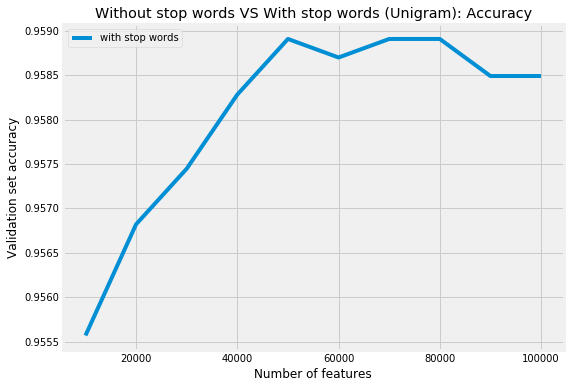

In [23]:
feature_result_ug = nfeature_accuracy_checker()
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
#nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
#nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
#plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
#plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 92.89%
accuracy score: 95.56%
model is 2.67% more accurate than null accuracy
train and test time: 0.94s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 92.89%
accuracy score: 95.66%
model is 2.77% more accurate than null accuracy
train and test time: 0.94s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 92.89%
accuracy score: 95.87%
model is 2.98% more accurate than null accuracy
train and test time: 0.95s
--------------------------------------------------------------------------------
Validation result f

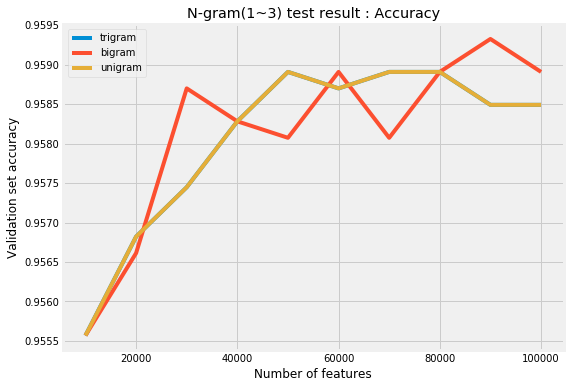

In [25]:
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))
feature_result_ug = nfeature_accuracy_checker()

nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 92.89%
accuracy score: 94.68%
model is 1.79% more accurate than null accuracy
train and test time: 1.37s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 92.89%
accuracy score: 94.56%
model is 1.67% more accurate than null accuracy
train and test time: 1.40s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 92.89%
accuracy score: 94.51%
model is 1.63% more accurate than null accuracy
train and test time: 1.42s
--------------------------------------------------------------------------------
Validation result f

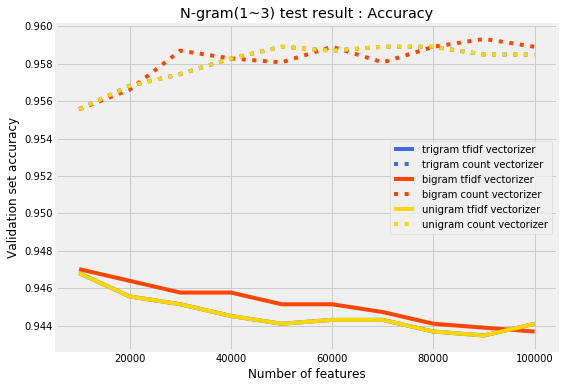

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))


nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [28]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

/Users/subir/anaconda3/envs/DeepLearning/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
null accuracy: 92.89%
accuracy score: 94.41%
model is 1.52% more accurate than null accuracy
train and test time: 1.44s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 92.89%
accuracy score: 96.35%
model is 3.46% more accurate than null accuracy
train and test time: 1.44s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-bas

In [29]:
trigram_result

[('Logistic Regression', 0.9440967876512307, 1.4380347728729248),
 ('Linear SVC', 0.9634960367125573, 1.435777187347412),
 ('LinearSVC with L1-based feature selection',
  0.9612015018773467,
  1.7904000282287598),
 ('Multinomial NB', 0.9390905298289528, 1.421860933303833),
 ('Bernoulli NB', 0.9372131831455986, 1.5730278491973877),
 ('Ridge Classifier', 0.9626616604088444, 1.8699300289154053),
 ('AdaBoost', 0.943471005423446, 3.201992988586426),
 ('Perceptron', 0.9545264914476429, 1.49786376953125),
 ('Passive-Aggresive', 0.9643304130162703, 1.2675118446350098),
 ('Nearest Centroid', 0.9361702127659575, 1.3939158916473389)]

In [30]:
from sklearn.ensemble import VotingClassifier


clf1 = LinearSVC()
clf2 =Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))])
clf3 = Perceptron()
clf4 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lc', clf1), ('svc', clf2), ('per', clf3), ('pac', clf4)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, eclf], ['Linear SVC', 'LinearSVC with L1-based feature selection', 'Perceptron', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print("Validation result for {}".format(label))
    print(clf)
    clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)

Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 92.89%
accuracy score: 96.35%
model is 3.46% more accurate than null accuracy
train and test time: 1.57s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
        norm_order=1, prefit...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
null accuracy: 92.89%
accuracy score: 96.12%
model is 3

/Users/subir/anaconda3/envs/DeepLearning/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
